In [1]:
import pandas as pd
import numpy as np
import os
import requests
import zipfile
from datetime import datetime
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist, pdist
import statsmodels.formula.api as smf
import urllib
import matplotlib.cm as cm
from sklearn import metrics
from sklearn import preprocessing
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=Warning)
%matplotlib inline

In [2]:
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans

def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

# Crime 2020 Data

In [3]:
Crime2020 = gpd.read_file("Data\clean_data\complaint2020Count\complaint2020Count.shp")

Crime2020['ZIPCODE'] = Crime2020['ZIPCODE'].astype(int)
Crime2020['date'] = pd.to_datetime(Crime2020['date'])

Crime2020['Month'] = Crime2020['date'].dt.month
Crime2020['DOW'] = Crime2020['date'].dt.dayofweek
Crime2020.head()

,date,ZIPCODE,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,COUNTY,geometry,Month,DOW
0,2020-03-01,83,0,1,1,0,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,6
1,2020-03-02,83,1,0,1,0,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,0
2,2020-03-04,83,0,0,1,0,0,1,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,2
3,2020-03-07,83,0,0,1,0,0,1,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,5
4,2020-03-10,83,0,1,1,0,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,1


In [4]:
Crime2020DOW = Crime2020.groupby(['DOW']).\
            agg({'other crim':'sum',
                 'personal c':'sum',
                 'property c':'sum',
                 'statutory':'sum', 
                 'traffic cr':'sum', 
                 'total':'sum', 
                 'POPULATION':'mean', 
                 'COUNTY':'count',  }).\
            rename(columns={'COUNTY':'Number of Crime Days'}).reset_index()
Crime2020DOW.head(10)

,DOW,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
0,0,1370,6382,10122,1000,132,19006,47490.788562,3060
1,1,1529,6270,9910,1095,153,18957,47433.737651,3057
2,2,1542,5944,9064,1223,161,17934,48110.668416,2859
3,3,1529,5698,8616,1181,153,17177,47868.998949,2855
4,4,1478,6155,8993,1211,175,18012,47278.700516,2905
5,5,1356,6406,8248,925,187,17122,47589.152637,2863
6,6,1265,6627,8280,874,223,17269,47585.707591,3030


(0.0, 25000.0)

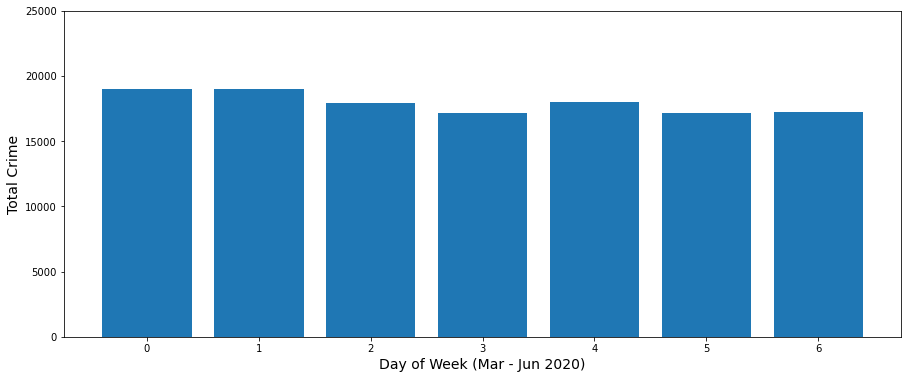

In [5]:
plt.figure(figsize=(15, 6))

plt.bar(Crime2020DOW.DOW, Crime2020DOW.total)
plt.xticks(Crime2020DOW.DOW)
plt.ylabel('Total Crime', fontsize=14)
plt.xlabel('Day of Week (Mar - Jun 2020)', fontsize=14)

plt.ylim([0, 25000])

In [6]:
Crime2020Month = Crime2020.groupby(['Month']).\
            agg({'other crim':'sum',
                 'personal c':'sum',
                 'property c':'sum',
                 'statutory':'sum', 
                 'traffic cr':'sum', 
                 'total':'sum', 
                 'POPULATION':'mean', 
                 'COUNTY':'count',  }).\
            rename(columns={'COUNTY':'Number of Crime Days'}).reset_index()
Crime2020Month.head(10)

,Month,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
0,3,2810,11596,16550,2183,371,33510,47259.368770,5277
1,4,2136,8515,13336,1337,210,25534,48632.475143,4908
2,5,2922,11145,16291,2392,330,33080,47604.352528,5262
3,6,2201,12226,17056,1597,273,33353,47037.480702,5182


(0.0, 40000.0)

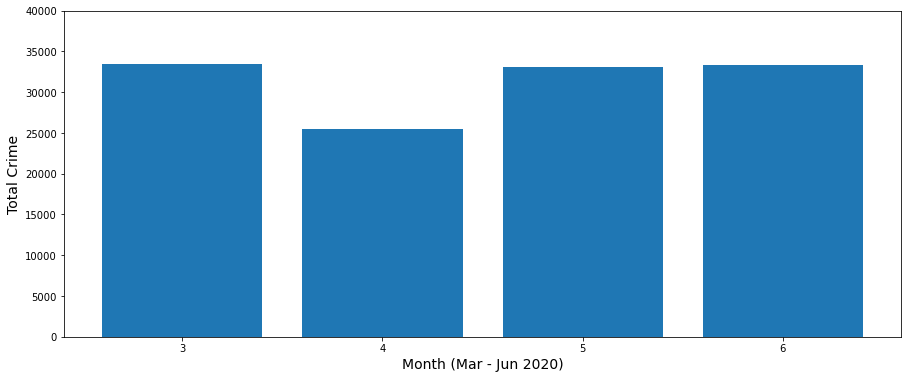

In [7]:
plt.figure(figsize=(15, 6))

plt.bar(Crime2020Month.Month, Crime2020Month.total)
plt.xticks(Crime2020Month.Month)
plt.ylabel('Total Crime', fontsize=14)
plt.xlabel('Month (Mar - Jun 2020)', fontsize=14)

plt.ylim([0, 40000])

In [8]:
Crime2020grouped = Crime2020.loc[(Crime2020['Month'] == 4 ) | (Crime2020['Month'] == 5 ) | (Crime2020['Month'] == 6 )]

Crime2020grouped = Crime2020.groupby(['ZIPCODE']).\
            agg({'other crim':'sum',
                 'personal c':'sum',
                 'property c':'sum',
                 'statutory':'sum', 
                 'traffic cr':'sum', 
                 'total':'sum', 
                 'POPULATION':'mean', 
                 'COUNTY':'count',  }).\
            rename(columns={'COUNTY':'Number of Crime Days'}).reset_index()

Crime2020grouped

,ZIPCODE,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
0,83,7,39,61,8,1,116,25.0,68
1,10001,56,266,692,66,1,1081,22413.0,122
2,10002,105,475,766,74,6,1426,81305.0,122
3,10003,57,227,669,38,2,993,55878.0,121
4,10004,16,88,148,20,4,276,2187.0,196
...,...,...,...,...,...,...,...,...,...
187,11691,152,511,500,66,11,1240,60267.0,122
188,11692,70,188,178,22,2,460,18018.0,117
189,11693,120,532,580,64,24,1320,11052.0,444
190,11694,16,83,96,6,4,205,20163.0,94


In [9]:
#Crime2020grouped['TotalCrimeNorm'] = Crime2020grouped['total']/(Crime2020grouped['POPULATION']/1000)

#Crime2020Apr = Crime2020grouped.loc[(Crime2020grouped['Month'] == 4 ) | (Crime2020grouped['Month'] == 5 ) | (Crime2020grouped['Month'] == 6 )]
Crime2020Apr = Crime2020grouped

In [10]:
min(Crime2020Apr['POPULATION']), max(Crime2020Apr['POPULATION'])

(0.0, 109069.0)

In [11]:
sanityindex = (Crime2020Apr['POPULATION'] > 1000)
Crime2020Apr = Crime2020Apr.loc[sanityindex]

In [12]:
Crime_ScaledApr = pd.DataFrame(columns = ['ZIPCODE', 'other crim', 'personal c', 'property c', 'statutory', 'traffic cr'])
Crime_ScaledApr['other crim'] = Crime2020Apr['other crim'] / (Crime2020Apr['POPULATION']/1000)
Crime_ScaledApr['personal c'] = Crime2020Apr['personal c'] / (Crime2020Apr['POPULATION']/1000)
Crime_ScaledApr['property c'] = Crime2020Apr['property c'] / (Crime2020Apr['POPULATION']/1000)
Crime_ScaledApr['statutory'] = Crime2020Apr['statutory'] / (Crime2020Apr['POPULATION']/1000)
Crime_ScaledApr['traffic cr'] = Crime2020Apr['traffic cr'] / (Crime2020Apr['POPULATION']/1000)
Crime_ScaledApr['ZIPCODE'] = Crime2020Apr['ZIPCODE']

Crime_ScaledApr.set_index('ZIPCODE', inplace=True)

Crime_ScaledApr

,other crim,personal c,property c,statutory,traffic cr
ZIPCODE,,,,,
10001,2.498550,11.868112,30.874939,2.944720,0.044617
10002,1.291433,5.842199,9.421315,0.910153,0.073796
10003,1.020079,4.062422,11.972512,0.680053,0.035792
10004,7.315958,40.237769,67.672611,9.144947,1.828989
10005,0.246700,2.220303,5.057358,0.986802,0.000000
...,...,...,...,...,...
11691,2.522110,8.478935,8.296414,1.095127,0.182521
11692,3.885004,10.434010,9.879010,1.221001,0.111000
11693,10.857763,48.136084,52.479189,5.790807,2.171553


In [13]:
#from sklearn.preprocessing import StandardScaler
#scale = StandardScaler()

In [14]:
#Crime2020Apr.iloc[:,2:8]

In [15]:
#Scaled = scale.fit_transform(Crime2020Apr.iloc[:,2:8])
#Crime_ScaledApr = pd.DataFrame(Scaled, columns = Crime2020Apr.columns[2:8])


#Crime2020Apr = Crime2020Apr.reset_index(drop=True)

#Crime_ScaledApr = Crime_ScaledApr.join(Crime2020Apr.iloc[:,0:1])

#Crime_ScaledApr.set_index('ZIPCODE', inplace=True)

#Crime_ScaledApr

In [16]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [ 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(Crime_ScaledApr)
    #report average Silhouette score
    silhouette_avg = silhouette_score(Crime_ScaledApr, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.8880681523114387
For n_clusters =3, the average silhouette_score is :0.5168039007032607
For n_clusters =4, the average silhouette_score is :0.5163434532389982
For n_clusters =5, the average silhouette_score is :0.42684538526826005
For n_clusters =6, the average silhouette_score is :0.42267208213228785
For n_clusters =7, the average silhouette_score is :0.3687166116600916
For n_clusters =8, the average silhouette_score is :0.3636063336286923
For n_clusters =9, the average silhouette_score is :0.36989350440097474
For n_clusters =10, the average silhouette_score is :0.34830355252107964
For n_clusters =11, the average silhouette_score is :0.3573750862321054
For n_clusters =12, the average silhouette_score is :0.3336955978835574
For n_clusters =13, the average silhouette_score is :0.35590104560816777
For n_clusters =14, the average silhouette_score is :0.3545006914611297
For n_clusters =15, the average silhouette_score is :0.347450003282

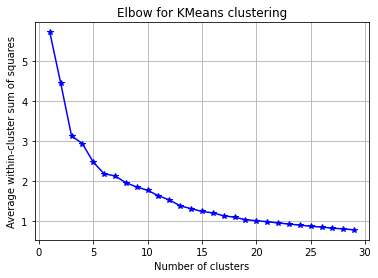

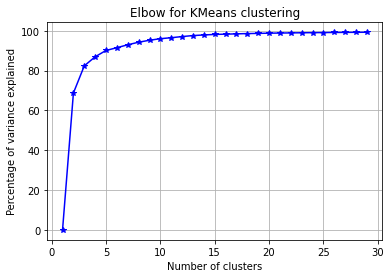

In [17]:
elbow(Crime_ScaledApr, range(1,30))

In [18]:
from sklearn.mixture import GaussianMixture # You can import this only if you are using 0.18+ sklearn.
GauMix = GaussianMixture(n_components = 4, random_state = 0).fit(Crime_ScaledApr)
GauMix.labels_ = GauMix.predict(Crime_ScaledApr) #get labels

max(GauMix.labels_)

3

In [19]:
res=pd.DataFrame({'ZIPCODE':Crime_ScaledApr.index,'label':GauMix.labels_})
res

,ZIPCODE,label
0,10001,0
1,10002,2
2,10003,2
3,10004,1
4,10005,3
...,...,...
177,11691,3
178,11692,3
179,11693,1
180,11694,2


In [20]:
clusterCrime2020Apr = Crime_ScaledApr.merge(res,left_index=True, right_on='ZIPCODE')
clusterCrime2020Apr

,other crim,personal c,property c,statutory,traffic cr,ZIPCODE,label
0,2.498550,11.868112,30.874939,2.944720,0.044617,10001,0
1,1.291433,5.842199,9.421315,0.910153,0.073796,10002,2
2,1.020079,4.062422,11.972512,0.680053,0.035792,10003,2
3,7.315958,40.237769,67.672611,9.144947,1.828989,10004,1
4,0.246700,2.220303,5.057358,0.986802,0.000000,10005,3
...,...,...,...,...,...,...,...
177,2.522110,8.478935,8.296414,1.095127,0.182521,11691,3
178,3.885004,10.434010,9.879010,1.221001,0.111000,11692,3
179,10.857763,48.136084,52.479189,5.790807,2.171553,11693,1
180,0.793533,4.116451,4.761196,0.297575,0.198383,11694,2


In [21]:
zips = gpd.read_file("Data/ZIP_CODE_040114/ZIP_CODE_040114.shp")
zips = zips[['ZIPCODE', 'POPULATION', 'geometry']]
zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)
zips.head()

,ZIPCODE,POPULATION,geometry
0,11436,18681.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,62426.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,83866.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,56527.0,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,72280.0,"POLYGON ((991997.113 176307.496, 992042.798 17..."


In [22]:
clusterCrime2020AprPlot = zips.merge(clusterCrime2020Apr,left_on='ZIPCODE',right_on='ZIPCODE',how='right')

clusterCrime2020AprPlot

,ZIPCODE,POPULATION,geometry,other crim,personal c,property c,statutory,traffic cr,label
0,10001,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",2.498550,11.868112,30.874939,2.944720,0.044617,0
1,10002,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",1.291433,5.842199,9.421315,0.910153,0.073796,2
2,10003,55878.0,"POLYGON ((989830.469 207048.126, 989716.354 20...",1.020079,4.062422,11.972512,0.680053,0.035792,2
3,10004,2187.0,"POLYGON ((981197.409 196571.082, 981485.049 19...",7.315958,40.237769,67.672611,9.144947,1.828989,1
4,10004,2187.0,"POLYGON ((972696.845 193014.548, 972500.000 19...",7.315958,40.237769,67.672611,9.144947,1.828989,1
...,...,...,...,...,...,...,...,...,...
189,11693,11052.0,"POLYGON ((1030722.649 160980.770, 1030642.283 ...",10.857763,48.136084,52.479189,5.790807,2.171553,1
190,11693,11052.0,"POLYGON ((1036087.150 154632.639, 1036096.661 ...",10.857763,48.136084,52.479189,5.790807,2.171553,1
191,11693,11052.0,"POLYGON ((1028453.995 167153.410, 1027813.010 ...",10.857763,48.136084,52.479189,5.790807,2.171553,1
192,11694,20163.0,"POLYGON ((1034425.420 153503.826, 1034416.180 ...",0.793533,4.116451,4.761196,0.297575,0.198383,2


In [23]:
clusterCrime2020AprPlot['label'] = clusterCrime2020AprPlot['label'].astype(str)

clusterCrime2020AprPlot = clusterCrime2020AprPlot[['ZIPCODE','label','geometry']]
clusterCrime2020AprPlot

,ZIPCODE,label,geometry
0,10001,0,"POLYGON ((981958.647 213464.453, 981980.328 21..."
1,10002,2,"POLYGON ((991339.870 207576.784, 991330.490 20..."
2,10003,2,"POLYGON ((989830.469 207048.126, 989716.354 20..."
3,10004,1,"POLYGON ((981197.409 196571.082, 981485.049 19..."
4,10004,1,"POLYGON ((972696.845 193014.548, 972500.000 19..."
...,...,...,...
189,11693,1,"POLYGON ((1030722.649 160980.770, 1030642.283 ..."
190,11693,1,"POLYGON ((1036087.150 154632.639, 1036096.661 ..."
191,11693,1,"POLYGON ((1028453.995 167153.410, 1027813.010 ..."
192,11694,2,"POLYGON ((1034425.420 153503.826, 1034416.180 ..."


In [24]:
clusterCrime2020AprPlot['label'] = clusterCrime2020AprPlot['label'].replace(['0','1','2','3'],['Cluster A','Cluster B','Cluster C','Cluster D'])
clusterCrime2020AprPlot

,ZIPCODE,label,geometry
0,10001,Cluster A,"POLYGON ((981958.647 213464.453, 981980.328 21..."
1,10002,Cluster C,"POLYGON ((991339.870 207576.784, 991330.490 20..."
2,10003,Cluster C,"POLYGON ((989830.469 207048.126, 989716.354 20..."
3,10004,Cluster B,"POLYGON ((981197.409 196571.082, 981485.049 19..."
4,10004,Cluster B,"POLYGON ((972696.845 193014.548, 972500.000 19..."
...,...,...,...
189,11693,Cluster B,"POLYGON ((1030722.649 160980.770, 1030642.283 ..."
190,11693,Cluster B,"POLYGON ((1036087.150 154632.639, 1036096.661 ..."
191,11693,Cluster B,"POLYGON ((1028453.995 167153.410, 1027813.010 ..."
192,11694,Cluster C,"POLYGON ((1034425.420 153503.826, 1034416.180 ..."


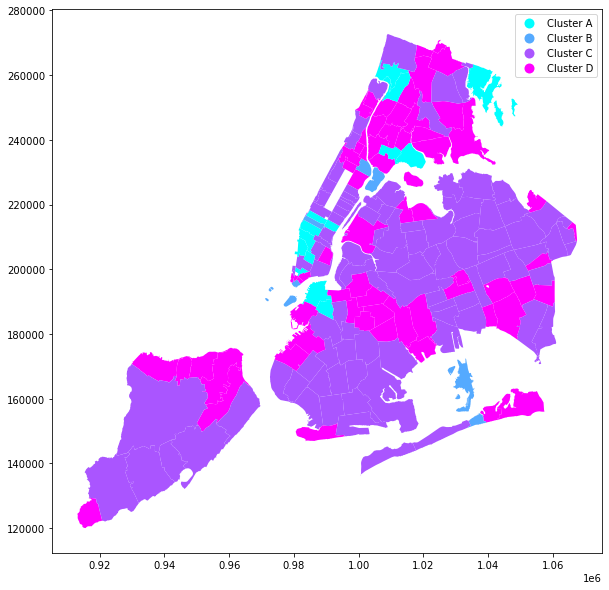

In [25]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize = (20,10))

clusterCrime2020AprPlot.plot(column = 'label', cmap = 'cool', legend = True, ax=ax)

In [26]:
clusterCrime2020AprGraph = Crime_ScaledApr.merge(res,left_index=True, right_on='ZIPCODE').\
                groupby(['label']).sum().reset_index()

clusterCrime2020AprGraph = clusterCrime2020AprGraph[['other crim','personal c', 'property c','statutory', 'traffic cr','label']]
clusterCrime2020AprGraph

,other crim,personal c,property c,statutory,traffic cr,label
0,22.235056,117.407940,230.882824,26.003061,2.250066,0
1,31.116459,140.361622,224.596889,36.115975,4.994642,1
2,71.809038,321.658351,551.411016,44.196894,9.984948,2
3,111.197739,444.417308,553.459613,74.600934,14.194273,3


In [27]:
clusterCrime2020AprGraph

clusterCrime2020AprGraph2 = clusterCrime2020AprGraph[[col for col in clusterCrime2020AprGraph.columns if col in ['other crim','personal c', 'property c','statutory', 'traffic cr']]]
clusterCrime2020AprGraph2 = clusterCrime2020AprGraph2.div(clusterCrime2020AprGraph2.sum(axis=1), axis=0)
clusterCrime2020AprGraph2['label'] = [0,1,2,3]
clusterCrime2020AprGraph2

,other crim,personal c,property c,statutory,traffic cr,label
0,0.055758,0.294419,0.578974,0.065207,0.005642,0
1,0.071174,0.321057,0.513734,0.082610,0.011425,1
2,0.071877,0.321961,0.551930,0.044238,0.009994,2
3,0.092830,0.371006,0.462037,0.062278,0.011850,3


In [28]:
clusterCrime2020AprGraph2['label'] = clusterCrime2020AprGraph2['label'].astype(str)

clusterCrime2020AprGraph2['label'] = clusterCrime2020AprGraph2['label'].replace(['0','1','2','3'],['Cluster A','Cluster B','Cluster C','Cluster D'])

clusterCrime2020AprGraph2 = clusterCrime2020AprGraph2.rename(columns={'other crim': 'other crimes', 'personal c': 'personal crimes', 'property c': 'property crimes', 'statutory': 'drug&alcohol', 'traffic cr': 'traffic crimes'})

clusterCrime2020AprGraph2

,other crimes,personal crimes,property crimes,drug&alcohol,traffic crimes,label
0,0.055758,0.294419,0.578974,0.065207,0.005642,Cluster A
1,0.071174,0.321057,0.513734,0.082610,0.011425,Cluster B
2,0.071877,0.321961,0.551930,0.044238,0.009994,Cluster C
3,0.092830,0.371006,0.462037,0.062278,0.011850,Cluster D


In [29]:
clusterCrime2020AprGraph2.set_index('label', inplace=True)

In [30]:
clusterCrime2020AprGraph2 = clusterCrime2020AprGraph2[["property crimes", "personal crimes", "other crimes", "traffic crimes", "drug&alcohol"]]
clusterCrime2020AprGraph2

,property crimes,personal crimes,other crimes,traffic crimes,drug&alcohol
label,,,,,
Cluster A,0.578974,0.294419,0.055758,0.005642,0.065207
Cluster B,0.513734,0.321057,0.071174,0.011425,0.082610
Cluster C,0.551930,0.321961,0.071877,0.009994,0.044238
Cluster D,0.462037,0.371006,0.092830,0.011850,0.062278


Text(0, 0.5, 'Crime Types')

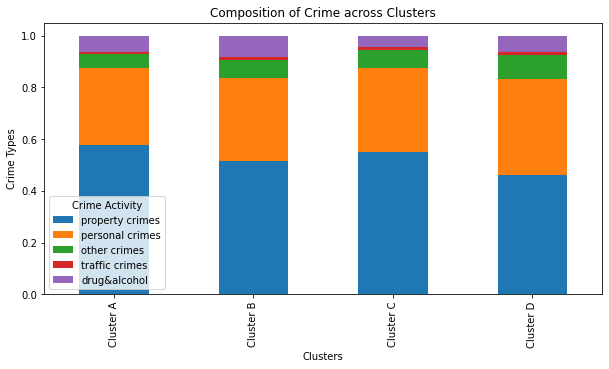

In [31]:
ax = clusterCrime2020AprGraph2.plot(kind='bar', stacked=True, legend=True, figsize=(10, 5))

plt.title("Composition of Crime across Clusters")
plt.legend(title="Crime Activity")
plt.xlabel("Clusters")
plt.ylabel("Crime Types")


# Crime 2017 Data

In [32]:
Crime2017 = gpd.read_file("Data\clean_data\complaint2017Count\complaint2017Count.shp")

Crime2017['ZIPCODE'] = Crime2017['ZIPCODE'].astype(int)
Crime2017['date'] = pd.to_datetime(Crime2017['date'])

Crime2017['Month'] = Crime2017['date'].dt.month
Crime2017['DOW'] = Crime2017['date'].dt.dayofweek
Crime2017.head()

,date,ZIPCODE,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,COUNTY,geometry,Month,DOW
0,2017-03-01,83,0,0,0,2,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,2
1,2017-03-03,83,0,1,1,0,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,4
2,2017-03-04,83,1,0,0,0,0,1,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,5
3,2017-03-06,83,0,0,2,0,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,0
4,2017-03-07,83,0,0,0,1,0,1,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,1


In [33]:

Crime2017.head()

,date,ZIPCODE,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,COUNTY,geometry,Month,DOW
0,2017-03-01,83,0,0,0,2,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,2
1,2017-03-03,83,0,1,1,0,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,4
2,2017-03-04,83,1,0,0,0,0,1,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,5
3,2017-03-06,83,0,0,2,0,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,0
4,2017-03-07,83,0,0,0,1,0,1,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,1


In [34]:
Crime2017grouped = Crime2017.groupby(['ZIPCODE', 'Month']).\
            agg({'other crim':'sum',
                 'personal c':'sum',
                 'property c':'sum',
                 'statutory':'sum', 
                 'traffic cr':'sum', 
                 'total':'sum', 
                 'POPULATION':'mean', 
                 'COUNTY':'count',  }).\
            rename(columns={'COUNTY':'Number of Crime Days'}).reset_index()
Crime2017grouped.head(10)

,ZIPCODE,Month,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
0,83,3,3,8,10,7,0,28,25.0,16
1,83,4,5,17,25,4,1,52,25.0,24
2,83,5,7,15,29,2,1,54,25.0,26
3,83,6,6,24,39,3,0,72,25.0,27
4,10001,3,30,66,276,23,3,398,22413.0,31
5,10001,4,37,75,282,25,3,422,22413.0,30
6,10001,5,30,97,310,24,3,464,22413.0,31
7,10001,6,27,100,336,17,5,485,22413.0,30
8,10002,3,46,131,192,54,3,426,81305.0,31
9,10002,4,55,148,195,60,1,459,81305.0,30


In [35]:
Crime2017Mar = Crime2017.loc[(Crime2017['Month'] == 3 )]
Crime2017Mar

,date,ZIPCODE,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,COUNTY,geometry,Month,DOW
0,2017-03-01,83,0,0,0,2,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,2
1,2017-03-03,83,0,1,1,0,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,4
2,2017-03-04,83,1,0,0,0,0,1,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,5
3,2017-03-06,83,0,0,2,0,0,2,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,0
4,2017-03-07,83,0,0,0,1,0,1,25.0,New York,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21505,2017-03-14,11109,0,1,0,0,0,1,2752.0,Queens,"POLYGON ((-73.95766 40.74629, -73.95718 40.746...",3,1
21506,2017-03-18,11109,0,0,1,0,0,1,2752.0,Queens,"POLYGON ((-73.95766 40.74629, -73.95718 40.746...",3,5
21524,2017-03-19,10112,1,0,0,0,0,1,0.0,New York,"POLYGON ((-73.98089 40.75927, -73.98071 40.759...",3,6
21525,2017-03-24,10112,0,1,0,0,0,1,0.0,New York,"POLYGON ((-73.98089 40.75927, -73.98071 40.759...",3,4


In [36]:
Crime2017DOW = Crime2017.groupby(['DOW']).\
            agg({'other crim':'sum',
                 'personal c':'sum',
                 'property c':'sum',
                 'statutory':'sum', 
                 'traffic cr':'sum', 
                 'total':'sum', 
                 'POPULATION':'mean', 
                 'COUNTY':'count',  }).\
            rename(columns={'COUNTY':'Number of Crime Days'}).reset_index()
Crime2017DOW.head(10)

,DOW,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
0,0,1920,7261,10635,1895,272,21983,46069.195559,3017
1,1,2345,7025,10199,2334,201,22104,46508.123656,2976
2,2,2721,7703,11486,2679,233,24822,46035.992498,3199
3,3,2631,7528,11274,2682,268,24383,46180.843593,3184
4,4,2583,7693,11840,2505,421,25042,45894.806974,3212
5,5,2185,7372,10208,2148,610,22523,46127.323393,3018
6,6,1855,7514,9032,1627,573,20601,46696.666441,2950


Text(0.5, 0, 'Day of Week (Mar - Jun 2017)')

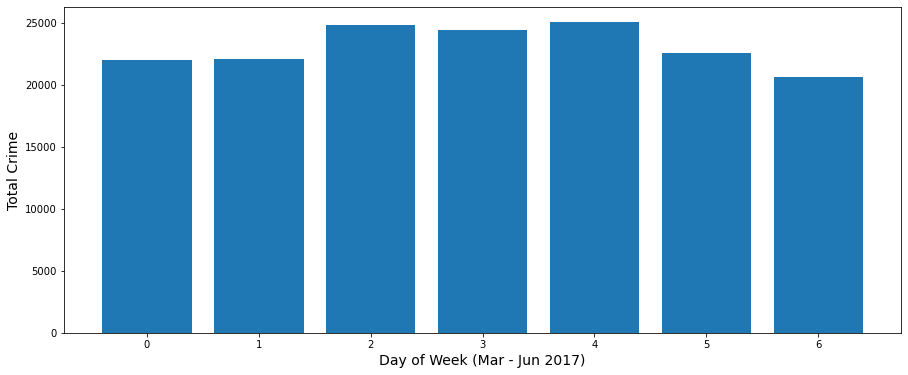

In [37]:
plt.figure(figsize=(15, 6))

plt.bar(Crime2017DOW.DOW, Crime2017DOW.total)
plt.xticks(Crime2017DOW.DOW)
plt.ylabel('Total Crime', fontsize=14)
plt.xlabel('Day of Week (Mar - Jun 2017)', fontsize=14)

In [38]:
Crime2017Month = Crime2017.groupby(['Month']).\
            agg({'other crim':'sum',
                 'personal c':'sum',
                 'property c':'sum',
                 'statutory':'sum', 
                 'traffic cr':'sum', 
                 'total':'sum', 
                 'POPULATION':'mean', 
                 'COUNTY':'count',  }).\
            rename(columns={'COUNTY':'Number of Crime Days'}).reset_index()
Crime2017Month.head(10)

,Month,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
0,3,4206,11806,17242,3990,644,37888,46556.724977,5425
1,4,4092,12487,18056,3991,622,39248,46413.047547,5279
2,5,4048,13856,19566,4051,689,42210,46065.447138,5486
3,6,3894,13947,19810,3838,623,42112,45805.009132,5366


Text(0.5, 0, 'Month (Mar - Jun 2017)')

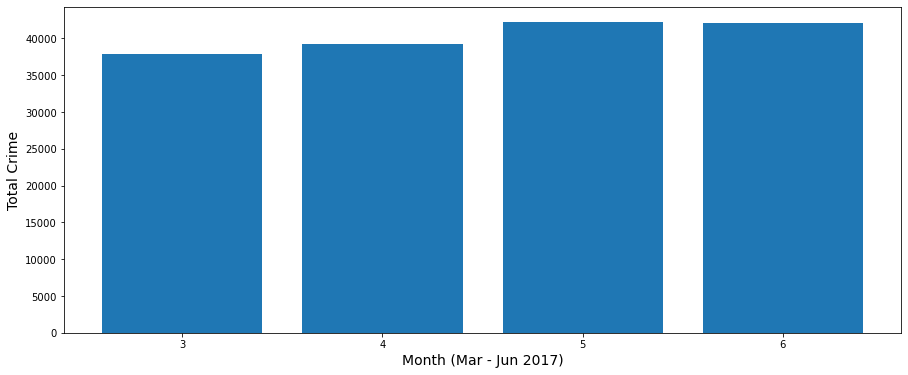

In [39]:
plt.figure(figsize=(15, 6))

plt.bar(Crime2017Month.Month, Crime2017Month.total)
plt.xticks(Crime2017Month.Month)
plt.ylabel('Total Crime', fontsize=14)
plt.xlabel('Month (Mar - Jun 2017)', fontsize=14)

In [40]:
Crime2017grouped = Crime2017.loc[(Crime2017['Month'] == 4 ) | (Crime2017['Month'] == 5 ) | (Crime2017['Month'] == 6 )]

Crime2017grouped = Crime2017.groupby(['ZIPCODE']).\
            agg({'other crim':'sum',
                 'personal c':'sum',
                 'property c':'sum',
                 'statutory':'sum', 
                 'traffic cr':'sum', 
                 'total':'sum', 
                 'POPULATION':'mean', 
                 'COUNTY':'count',  }).\
            rename(columns={'COUNTY':'Number of Crime Days'}).reset_index()

Crime2017grouped.head(10)

,ZIPCODE,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
0,83,21,64,103,16,2,206,25.0,93
1,10001,124,338,1204,89,14,1769,22413.0,122
2,10002,204,602,842,241,11,1900,81305.0,122
3,10003,77,286,965,71,6,1405,55878.0,122
4,10004,92,184,476,80,0,832,2187.0,412
5,10005,8,22,54,12,0,96,8107.0,67
6,10006,4,35,71,15,0,125,3011.0,80
7,10007,20,58,309,27,1,415,7323.0,120
8,10009,112,264,521,123,3,1023,61455.0,121
9,10010,75,205,363,56,8,707,29881.0,122


Crime2017grouped['TotalCrimeNorm'] = Crime2017grouped['total']/(Crime2017grouped['POPULATION']/1000)
Crime2017grouped


In [41]:
#Crime2017Apr = Crime2017grouped.loc[(Crime2017grouped['Month'] == 4 ) | (Crime2017grouped['Month'] == 5 ) | (Crime2017grouped['Month'] == 6 )]
Crime2017Apr = Crime2017grouped

In [42]:
min(Crime2017Apr['POPULATION']), max(Crime2017Apr['POPULATION'])

(0.0, 109069.0)

In [43]:
sanityindex = (Crime2017Apr['POPULATION'] > 1000)
Crime2017Apr = Crime2017Apr.loc[sanityindex]

In [44]:
Crime_ScaledApr = pd.DataFrame(columns = ['ZIPCODE', 'other crim', 'personal c', 'property c', 'statutory', 'traffic cr'])
Crime_ScaledApr['other crim'] = Crime2017Apr['other crim'] / (Crime2017Apr['POPULATION']/1000)
Crime_ScaledApr['personal c'] = Crime2017Apr['personal c'] / (Crime2017Apr['POPULATION']/1000)
Crime_ScaledApr['property c'] = Crime2017Apr['property c'] / (Crime2017Apr['POPULATION']/1000)
Crime_ScaledApr['statutory'] = Crime2017Apr['statutory'] / (Crime2017Apr['POPULATION']/1000)
Crime_ScaledApr['traffic cr'] = Crime2017Apr['traffic cr'] / (Crime2017Apr['POPULATION']/1000)
Crime_ScaledApr['ZIPCODE'] = Crime2017Apr['ZIPCODE']

Crime_ScaledApr.set_index('ZIPCODE', inplace=True)

Crime_ScaledApr

,other crim,personal c,property c,statutory,traffic cr
ZIPCODE,,,,,
10001,5.532503,15.080534,53.718824,3.970910,0.624637
10002,2.509071,7.404219,10.356067,2.964147,0.135293
10003,1.378002,5.118293,17.269766,1.270625,0.107377
10004,42.066758,84.133516,217.649749,36.579790,0.000000
10005,0.986802,2.713704,6.660910,1.480202,0.000000
...,...,...,...,...,...
11691,3.268787,8.694642,8.329600,1.476762,0.398228
11692,4.495504,9.879010,8.491508,1.942502,0.277500
11693,26.420557,47.774159,46.688382,18.096272,2.533478


In [45]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [ 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(Crime_ScaledApr)
    #report average Silhouette score
    silhouette_avg = silhouette_score(Crime_ScaledApr, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.9491963858012382
For n_clusters =3, the average silhouette_score is :0.83610972461727
For n_clusters =4, the average silhouette_score is :0.49451857593809456
For n_clusters =5, the average silhouette_score is :0.4994495112377285
For n_clusters =6, the average silhouette_score is :0.49986203522764444
For n_clusters =7, the average silhouette_score is :0.45038146116565614
For n_clusters =8, the average silhouette_score is :0.35862905631262393
For n_clusters =9, the average silhouette_score is :0.3556466650044568
For n_clusters =10, the average silhouette_score is :0.3575165333211404
For n_clusters =11, the average silhouette_score is :0.3596817927863941
For n_clusters =12, the average silhouette_score is :0.35528608481329366
For n_clusters =13, the average silhouette_score is :0.3085500456259381
For n_clusters =14, the average silhouette_score is :0.31742776674838885
For n_clusters =15, the average silhouette_score is :0.3078317365040

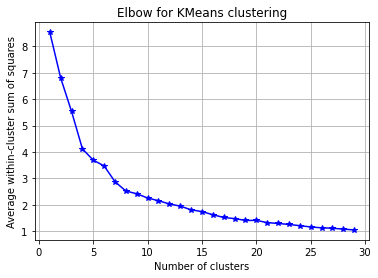

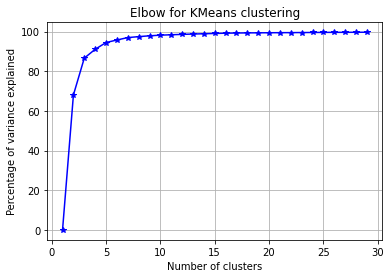

In [46]:
elbow(Crime_ScaledApr, range(1,30))

In [47]:
from sklearn.mixture import GaussianMixture # You can import this only if you are using 0.18+ sklearn.
GauMix = GaussianMixture(n_components = 4, random_state = 0).fit(Crime_ScaledApr)
GauMix.labels_ = GauMix.predict(Crime_ScaledApr) #get labels

max(GauMix.labels_)

3

In [48]:
res=pd.DataFrame({'ZIPCODE':Crime_ScaledApr.index,'label':GauMix.labels_})
res

,ZIPCODE,label
0,10001,3
1,10002,0
2,10003,0
3,10004,1
4,10005,0
...,...,...
177,11691,0
178,11692,0
179,11693,2
180,11694,0


In [49]:
clusterCrime2017Apr = Crime_ScaledApr.merge(res,left_index=True, right_on='ZIPCODE')
clusterCrime2017Apr

,other crim,personal c,property c,statutory,traffic cr,ZIPCODE,label
0,5.532503,15.080534,53.718824,3.970910,0.624637,10001,3
1,2.509071,7.404219,10.356067,2.964147,0.135293,10002,0
2,1.378002,5.118293,17.269766,1.270625,0.107377,10003,0
3,42.066758,84.133516,217.649749,36.579790,0.000000,10004,1
4,0.986802,2.713704,6.660910,1.480202,0.000000,10005,0
...,...,...,...,...,...,...,...
177,3.268787,8.694642,8.329600,1.476762,0.398228,11691,0
178,4.495504,9.879010,8.491508,1.942502,0.277500,11692,0
179,26.420557,47.774159,46.688382,18.096272,2.533478,11693,2
180,0.991916,3.620493,5.653921,0.892724,0.247979,11694,0


In [50]:
zips = gpd.read_file("Data/ZIP_CODE_040114/ZIP_CODE_040114.shp")
zips = zips[['ZIPCODE', 'POPULATION', 'geometry']]
zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)
zips.head()

,ZIPCODE,POPULATION,geometry
0,11436,18681.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,62426.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,83866.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,56527.0,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,72280.0,"POLYGON ((991997.113 176307.496, 992042.798 17..."


In [51]:
clusterCrime2017AprPlot = zips.merge(clusterCrime2017Apr,left_on='ZIPCODE',right_on='ZIPCODE',how='right')

clusterCrime2017AprPlot

,ZIPCODE,POPULATION,geometry,other crim,personal c,property c,statutory,traffic cr,label
0,10001,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",5.532503,15.080534,53.718824,3.970910,0.624637,3
1,10002,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",2.509071,7.404219,10.356067,2.964147,0.135293,0
2,10003,55878.0,"POLYGON ((989830.469 207048.126, 989716.354 20...",1.378002,5.118293,17.269766,1.270625,0.107377,0
3,10004,2187.0,"POLYGON ((981197.409 196571.082, 981485.049 19...",42.066758,84.133516,217.649749,36.579790,0.000000,1
4,10004,2187.0,"POLYGON ((972696.845 193014.548, 972500.000 19...",42.066758,84.133516,217.649749,36.579790,0.000000,1
...,...,...,...,...,...,...,...,...,...
189,11693,11052.0,"POLYGON ((1030722.649 160980.770, 1030642.283 ...",26.420557,47.774159,46.688382,18.096272,2.533478,2
190,11693,11052.0,"POLYGON ((1036087.150 154632.639, 1036096.661 ...",26.420557,47.774159,46.688382,18.096272,2.533478,2
191,11693,11052.0,"POLYGON ((1028453.995 167153.410, 1027813.010 ...",26.420557,47.774159,46.688382,18.096272,2.533478,2
192,11694,20163.0,"POLYGON ((1034425.420 153503.826, 1034416.180 ...",0.991916,3.620493,5.653921,0.892724,0.247979,0


In [52]:
clusterCrime2017AprPlot['label'] = clusterCrime2017AprPlot['label'].astype(str)

clusterCrime2017AprPlot = clusterCrime2017AprPlot[['ZIPCODE','label','geometry']]
clusterCrime2017AprPlot

,ZIPCODE,label,geometry
0,10001,3,"POLYGON ((981958.647 213464.453, 981980.328 21..."
1,10002,0,"POLYGON ((991339.870 207576.784, 991330.490 20..."
2,10003,0,"POLYGON ((989830.469 207048.126, 989716.354 20..."
3,10004,1,"POLYGON ((981197.409 196571.082, 981485.049 19..."
4,10004,1,"POLYGON ((972696.845 193014.548, 972500.000 19..."
...,...,...,...
189,11693,2,"POLYGON ((1030722.649 160980.770, 1030642.283 ..."
190,11693,2,"POLYGON ((1036087.150 154632.639, 1036096.661 ..."
191,11693,2,"POLYGON ((1028453.995 167153.410, 1027813.010 ..."
192,11694,0,"POLYGON ((1034425.420 153503.826, 1034416.180 ..."


In [53]:
clusterCrime2017AprPlot['label'] = clusterCrime2017AprPlot['label'].replace(['0','1','2','3'],['Cluster A','Cluster B','Cluster C','Cluster D'])
clusterCrime2017AprPlot

,ZIPCODE,label,geometry
0,10001,Cluster D,"POLYGON ((981958.647 213464.453, 981980.328 21..."
1,10002,Cluster A,"POLYGON ((991339.870 207576.784, 991330.490 20..."
2,10003,Cluster A,"POLYGON ((989830.469 207048.126, 989716.354 20..."
3,10004,Cluster B,"POLYGON ((981197.409 196571.082, 981485.049 19..."
4,10004,Cluster B,"POLYGON ((972696.845 193014.548, 972500.000 19..."
...,...,...,...
189,11693,Cluster C,"POLYGON ((1030722.649 160980.770, 1030642.283 ..."
190,11693,Cluster C,"POLYGON ((1036087.150 154632.639, 1036096.661 ..."
191,11693,Cluster C,"POLYGON ((1028453.995 167153.410, 1027813.010 ..."
192,11694,Cluster A,"POLYGON ((1034425.420 153503.826, 1034416.180 ..."


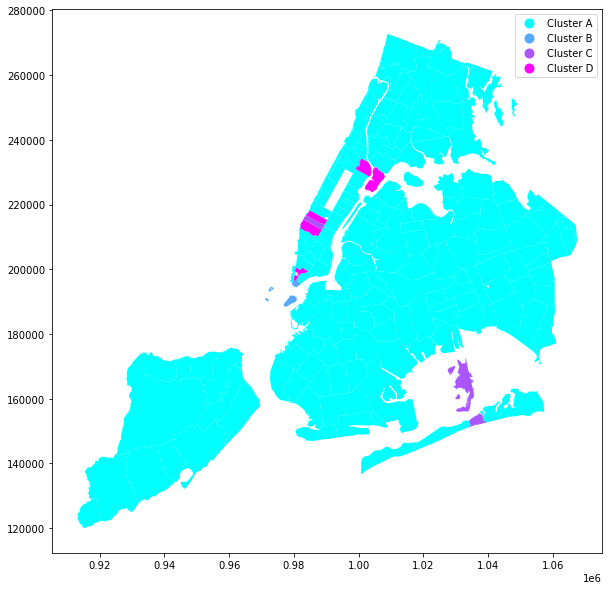

In [54]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize = (20,10))

clusterCrime2017AprPlot.plot(column = 'label', cmap = 'cool', legend = True, ax=ax)

In [55]:
clusterCrime2017AprGraph = Crime_ScaledApr.merge(res,left_index=True, right_on='ZIPCODE').\
                groupby(['label']).sum().reset_index()

clusterCrime2017AprGraph = clusterCrime2017AprGraph[['other crim','personal c', 'property c','statutory', 'traffic cr','label']]
clusterCrime2017AprGraph

,other crim,personal c,property c,statutory,traffic cr,label
0,312.531125,1015.928809,1471.245214,299.230639,53.889190,0
1,42.066758,84.133516,217.649749,36.579790,0.000000,1
2,43.865587,100.290968,133.186656,34.450988,3.442073,2
3,31.023083,79.911757,190.595299,42.562749,2.421750,3


In [56]:
clusterCrime2017AprGraph

clusterCrime2017AprGraph2 = clusterCrime2017AprGraph[[col for col in clusterCrime2017AprGraph.columns if col in ['other crim','personal c', 'property c','statutory', 'traffic cr']]]
clusterCrime2017AprGraph2 = clusterCrime2017AprGraph2.div(clusterCrime2017AprGraph2.sum(axis=1), axis=0)
clusterCrime2017AprGraph2['label'] = [0,1,2,3]
clusterCrime2017AprGraph2

,other crim,personal c,property c,statutory,traffic cr,label
0,0.099127,0.322228,0.466643,0.094909,0.017092,0
1,0.110577,0.221154,0.572115,0.096154,0.000000,1
2,0.139151,0.318145,0.422498,0.109286,0.010919,2
3,0.089529,0.230616,0.550035,0.122831,0.006989,3


In [57]:
clusterCrime2017AprGraph2['label'] = clusterCrime2017AprGraph2['label'].astype(str)

clusterCrime2017AprGraph2['label'] = clusterCrime2017AprGraph2['label'].replace(['0','1','2','3'],['Cluster A','Cluster B','Cluster C','Cluster D'])

clusterCrime2017AprGraph2 = clusterCrime2017AprGraph2.rename(columns={'other crim': 'other crimes', 'personal c': 'personal crimes', 'property c': 'property crimes', 'statutory': 'drug&alcohol', 'traffic cr': 'traffic crimes'})

clusterCrime2017AprGraph2

,other crimes,personal crimes,property crimes,drug&alcohol,traffic crimes,label
0,0.099127,0.322228,0.466643,0.094909,0.017092,Cluster A
1,0.110577,0.221154,0.572115,0.096154,0.000000,Cluster B
2,0.139151,0.318145,0.422498,0.109286,0.010919,Cluster C
3,0.089529,0.230616,0.550035,0.122831,0.006989,Cluster D


In [58]:
clusterCrime2017AprGraph2.set_index('label', inplace=True)

In [59]:
clusterCrime2017AprGraph2 = clusterCrime2017AprGraph2[["property crimes", "personal crimes", "other crimes", "traffic crimes", "drug&alcohol"]]
clusterCrime2017AprGraph2

,property crimes,personal crimes,other crimes,traffic crimes,drug&alcohol
label,,,,,
Cluster A,0.466643,0.322228,0.099127,0.017092,0.094909
Cluster B,0.572115,0.221154,0.110577,0.000000,0.096154
Cluster C,0.422498,0.318145,0.139151,0.010919,0.109286
Cluster D,0.550035,0.230616,0.089529,0.006989,0.122831


Text(0, 0.5, 'Crime Types')

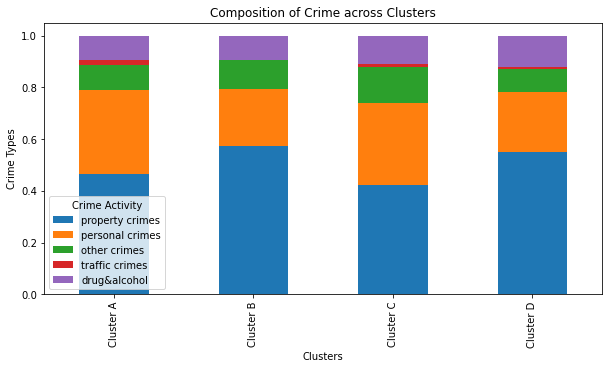

In [60]:
ax = clusterCrime2017AprGraph2.plot(kind='bar', stacked=True, legend=True, figsize=(10, 5))

plt.title("Composition of Crime across Clusters")
plt.legend(title="Crime Activity")
plt.xlabel("Clusters")
plt.ylabel("Crime Types")

# Crime 2018 Data

In [61]:
Crime2018 = gpd.read_file("Data\clean_data\complaint2018Count\complaint2018Count.shp")

Crime2018['ZIPCODE'] = Crime2018['ZIPCODE'].astype(int)
Crime2018['date'] = pd.to_datetime(Crime2018['date'])

Crime2018['Month'] = Crime2018['date'].dt.month
Crime2018['DOW'] = Crime2018['date'].dt.dayofweek
Crime2018.head()

,date,ZIPCODE,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,COUNTY,geometry,Month,DOW
0,2018-03-01,10001,2,6,9,1,0,18,22413.0,New York,"POLYGON ((-74.00827 40.75259, -74.00819 40.752...",3,3
1,2018-03-02,10001,1,3,10,1,0,15,22413.0,New York,"POLYGON ((-74.00827 40.75259, -74.00819 40.752...",3,4
2,2018-03-03,10001,1,2,19,1,0,23,22413.0,New York,"POLYGON ((-74.00827 40.75259, -74.00819 40.752...",3,5
3,2018-03-04,10001,2,2,13,1,0,18,22413.0,New York,"POLYGON ((-74.00827 40.75259, -74.00819 40.752...",3,6
4,2018-03-05,10001,2,3,10,1,0,16,22413.0,New York,"POLYGON ((-74.00827 40.75259, -74.00819 40.752...",3,0


In [62]:
Crime2018DOW = Crime2018.groupby(['DOW']).\
            agg({'other crim':'sum',
                 'personal c':'sum',
                 'property c':'sum',
                 'statutory':'sum', 
                 'traffic cr':'sum', 
                 'total':'sum', 
                 'POPULATION':'mean', 
                 'COUNTY':'count',  }).\
            rename(columns={'COUNTY':'Number of Crime Days'}).reset_index()
Crime2018DOW.head(10)

,DOW,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
0,0,1889,7567,10403,1653,246,21758,46447.651723,2989
1,1,2283,7413,10421,2037,196,22350,46411.653409,2992
2,2,2411,7318,10448,2015,224,22416,46078.245864,3022
3,3,2614,7992,11418,2177,272,24473,46080.970625,3200
4,4,2597,8394,12188,2222,357,25758,45705.385043,3236
5,5,2258,8397,10792,1858,575,23880,45968.986533,3193
6,6,1760,8134,9151,1547,546,21138,46954.866144,2936


Text(0.5, 0, 'Day of Week (Mar - Jun 2018)')

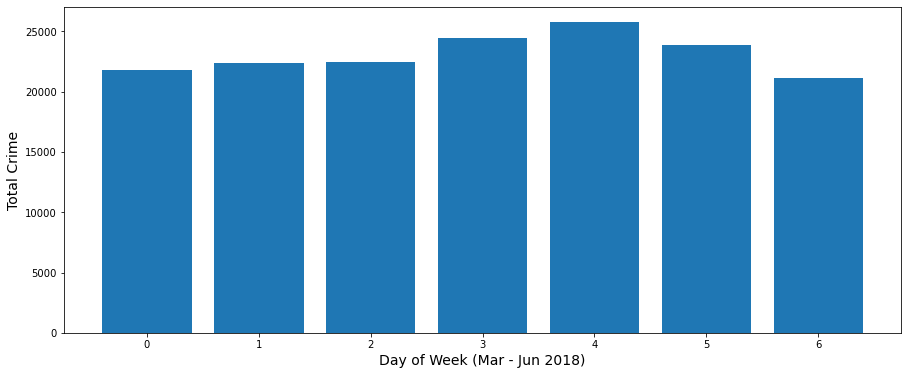

In [63]:
plt.figure(figsize=(15, 6))

plt.bar(Crime2018DOW.DOW, Crime2018DOW.total)
plt.xticks(Crime2018DOW.DOW)
plt.ylabel('Total Crime', fontsize=14)
plt.xlabel('Day of Week (Mar - Jun 2018)', fontsize=14)

In [64]:
Crime2018Month = Crime2018.groupby(['Month']).\
            agg({'other crim':'sum',
                 'personal c':'sum',
                 'property c':'sum',
                 'statutory':'sum', 
                 'traffic cr':'sum', 
                 'total':'sum', 
                 'POPULATION':'mean', 
                 'COUNTY':'count',  }).\
            rename(columns={'COUNTY':'Number of Crime Days'}).reset_index()
Crime2018Month.head(10)

,Month,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
0,3,4137,12801,17559,3624,653,38774,46734.027474,5387
1,4,3846,12974,17931,3537,594,38882,46364.672971,5287
2,5,4077,15042,19624,3419,577,42739,45884.722172,5525
3,6,3752,14398,19707,2929,592,41378,45920.102067,5369


Text(0.5, 0, 'Month (Mar - Jun 2018)')

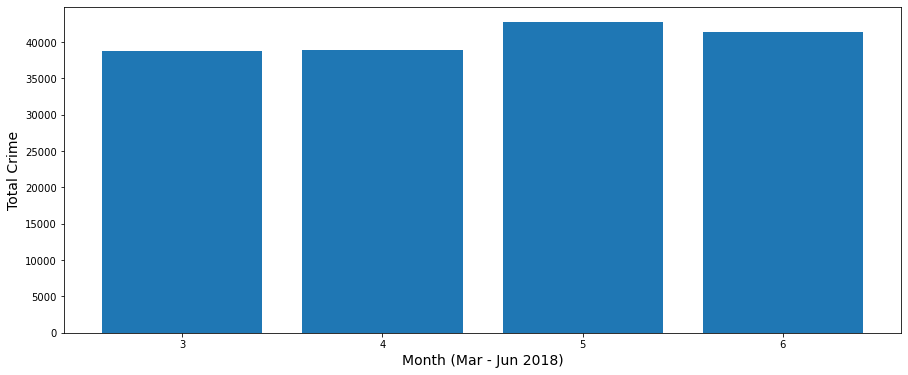

In [65]:
plt.figure(figsize=(15, 6))

plt.bar(Crime2018Month.Month, Crime2018Month.total)
plt.xticks(Crime2018Month.Month)
plt.ylabel('Total Crime', fontsize=14)
plt.xlabel('Month (Mar - Jun 2018)', fontsize=14)

In [66]:
Crime2018grouped = Crime2018.loc[(Crime2018['Month'] == 4 ) | (Crime2018['Month'] == 5 ) | (Crime2018['Month'] == 6 )]

Crime2018grouped = Crime2018.groupby(['ZIPCODE']).\
            agg({'other crim':'sum',
                 'personal c':'sum',
                 'property c':'sum',
                 'statutory':'sum', 
                 'traffic cr':'sum', 
                 'total':'sum', 
                 'POPULATION':'mean', 
                 'COUNTY':'count',  }).\
            rename(columns={'COUNTY':'Number of Crime Days'}).reset_index()

Crime2018grouped.head(10)

,ZIPCODE,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
0,83,20,56,79,13,0,168,25.0,82
1,10001,160,376,1377,119,5,2037,22413.0,122
2,10002,162,553,854,126,9,1704,81305.0,122
3,10003,64,323,1000,80,7,1474,55878.0,122
4,10004,112,232,420,48,4,816,2187.0,388
5,10005,3,36,115,22,0,176,8107.0,82
6,10006,4,31,63,16,2,116,3011.0,68
7,10007,17,78,338,28,1,462,7323.0,116
8,10009,96,277,471,97,6,947,61455.0,122
9,10010,71,199,361,43,6,680,29881.0,121


In [67]:
#Crime2018Apr = Crime2018grouped.loc[(Crime2018grouped['Month'] == 4 ) | (Crime2018grouped['Month'] == 5 ) | (Crime2018grouped['Month'] == 6 )]
Crime2018Apr = Crime2018grouped

In [68]:
min(Crime2018Apr['POPULATION']), max(Crime2018Apr['POPULATION'])

(0.0, 109069.0)

In [69]:
sanityindex = (Crime2018Apr['POPULATION'] > 1000)
Crime2018Apr = Crime2018Apr.loc[sanityindex]

In [70]:
Crime_ScaledApr = pd.DataFrame(columns = ['ZIPCODE', 'other crim', 'personal c', 'property c', 'statutory', 'traffic cr'])
Crime_ScaledApr['other crim'] = Crime2018Apr['other crim'] / (Crime2018Apr['POPULATION']/1000)
Crime_ScaledApr['personal c'] = Crime2018Apr['personal c'] / (Crime2018Apr['POPULATION']/1000)
Crime_ScaledApr['property c'] = Crime2018Apr['property c'] / (Crime2018Apr['POPULATION']/1000)
Crime_ScaledApr['statutory'] = Crime2018Apr['statutory'] / (Crime2018Apr['POPULATION']/1000)
Crime_ScaledApr['traffic cr'] = Crime2018Apr['traffic cr'] / (Crime2018Apr['POPULATION']/1000)
Crime_ScaledApr['ZIPCODE'] = Crime2018Apr['ZIPCODE']

Crime_ScaledApr.set_index('ZIPCODE', inplace=True)

Crime_ScaledApr

,other crim,personal c,property c,statutory,traffic cr
ZIPCODE,,,,,
10001,7.138714,16.775978,61.437559,5.309419,0.223085
10002,1.992497,6.801550,10.503659,1.549720,0.110694
10003,1.145352,5.780450,17.896131,1.431690,0.125273
10004,51.211706,106.081390,192.043896,21.947874,1.828989
10005,0.370051,4.440607,14.185272,2.713704,0.000000
...,...,...,...,...,...
11691,3.517680,9.175834,7.782037,1.891582,0.232300
11692,4.107004,7.270507,5.328005,1.942502,0.388500
11693,22.439377,39.811799,49.945711,13.029316,1.809627


In [71]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [ 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(Crime_ScaledApr)
    #report average Silhouette score
    silhouette_avg = silhouette_score(Crime_ScaledApr, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.927905105388994
For n_clusters =3, the average silhouette_score is :0.8264428722665722
For n_clusters =4, the average silhouette_score is :0.5391071155086392
For n_clusters =5, the average silhouette_score is :0.4754902091801037
For n_clusters =6, the average silhouette_score is :0.461946823738866
For n_clusters =7, the average silhouette_score is :0.4646739231950607
For n_clusters =8, the average silhouette_score is :0.4643995040758782
For n_clusters =9, the average silhouette_score is :0.3603157769686899
For n_clusters =10, the average silhouette_score is :0.36055939924516567
For n_clusters =11, the average silhouette_score is :0.31730785071383993
For n_clusters =12, the average silhouette_score is :0.35358476603323513
For n_clusters =13, the average silhouette_score is :0.3490329066800937
For n_clusters =14, the average silhouette_score is :0.346648991209405
For n_clusters =15, the average silhouette_score is :0.34997499732978693

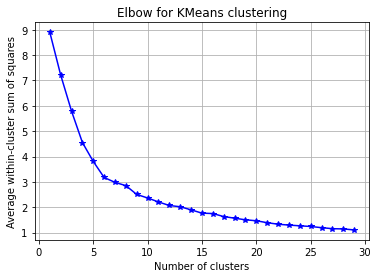

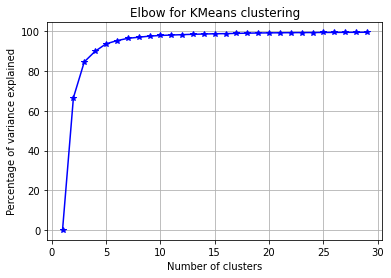

In [72]:
elbow(Crime_ScaledApr, range(1,30))

In [73]:
from sklearn.mixture import GaussianMixture # You can import this only if you are using 0.18+ sklearn.
GauMix = GaussianMixture(n_components = 4, random_state = 0).fit(Crime_ScaledApr)
GauMix.labels_ = GauMix.predict(Crime_ScaledApr) #get labels

max(GauMix.labels_)

3

In [74]:
res=pd.DataFrame({'ZIPCODE':Crime_ScaledApr.index,'label':GauMix.labels_})
res

,ZIPCODE,label
0,10001,2
1,10002,0
2,10003,3
3,10004,1
4,10005,3
...,...,...
177,11691,0
178,11692,3
179,11693,2
180,11694,0


In [75]:
clusterCrime2018Apr = Crime_ScaledApr.merge(res,left_index=True, right_on='ZIPCODE')
clusterCrime2018Apr

,other crim,personal c,property c,statutory,traffic cr,ZIPCODE,label
0,7.138714,16.775978,61.437559,5.309419,0.223085,10001,2
1,1.992497,6.801550,10.503659,1.549720,0.110694,10002,0
2,1.145352,5.780450,17.896131,1.431690,0.125273,10003,3
3,51.211706,106.081390,192.043896,21.947874,1.828989,10004,1
4,0.370051,4.440607,14.185272,2.713704,0.000000,10005,3
...,...,...,...,...,...,...,...
177,3.517680,9.175834,7.782037,1.891582,0.232300,11691,0
178,4.107004,7.270507,5.328005,1.942502,0.388500,11692,3
179,22.439377,39.811799,49.945711,13.029316,1.809627,11693,2
180,1.289491,4.265238,3.918068,0.743937,0.347171,11694,0


In [76]:
zips = gpd.read_file("Data/ZIP_CODE_040114/ZIP_CODE_040114.shp")
zips = zips[['ZIPCODE', 'POPULATION', 'geometry']]
zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)
zips.head()

,ZIPCODE,POPULATION,geometry
0,11436,18681.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,62426.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,83866.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,56527.0,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,72280.0,"POLYGON ((991997.113 176307.496, 992042.798 17..."


In [77]:
clusterCrime2018AprPlot = zips.merge(clusterCrime2018Apr,left_on='ZIPCODE',right_on='ZIPCODE',how='right')

clusterCrime2018AprPlot

,ZIPCODE,POPULATION,geometry,other crim,personal c,property c,statutory,traffic cr,label
0,10001,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",7.138714,16.775978,61.437559,5.309419,0.223085,2
1,10002,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",1.992497,6.801550,10.503659,1.549720,0.110694,0
2,10003,55878.0,"POLYGON ((989830.469 207048.126, 989716.354 20...",1.145352,5.780450,17.896131,1.431690,0.125273,3
3,10004,2187.0,"POLYGON ((981197.409 196571.082, 981485.049 19...",51.211706,106.081390,192.043896,21.947874,1.828989,1
4,10004,2187.0,"POLYGON ((972696.845 193014.548, 972500.000 19...",51.211706,106.081390,192.043896,21.947874,1.828989,1
...,...,...,...,...,...,...,...,...,...
189,11693,11052.0,"POLYGON ((1030722.649 160980.770, 1030642.283 ...",22.439377,39.811799,49.945711,13.029316,1.809627,2
190,11693,11052.0,"POLYGON ((1036087.150 154632.639, 1036096.661 ...",22.439377,39.811799,49.945711,13.029316,1.809627,2
191,11693,11052.0,"POLYGON ((1028453.995 167153.410, 1027813.010 ...",22.439377,39.811799,49.945711,13.029316,1.809627,2
192,11694,20163.0,"POLYGON ((1034425.420 153503.826, 1034416.180 ...",1.289491,4.265238,3.918068,0.743937,0.347171,0


In [78]:
clusterCrime2018AprPlot['label'] = clusterCrime2018AprPlot['label'].astype(str)

clusterCrime2018AprPlot = clusterCrime2018AprPlot[['ZIPCODE','label','geometry']]
clusterCrime2018AprPlot

,ZIPCODE,label,geometry
0,10001,2,"POLYGON ((981958.647 213464.453, 981980.328 21..."
1,10002,0,"POLYGON ((991339.870 207576.784, 991330.490 20..."
2,10003,3,"POLYGON ((989830.469 207048.126, 989716.354 20..."
3,10004,1,"POLYGON ((981197.409 196571.082, 981485.049 19..."
4,10004,1,"POLYGON ((972696.845 193014.548, 972500.000 19..."
...,...,...,...
189,11693,2,"POLYGON ((1030722.649 160980.770, 1030642.283 ..."
190,11693,2,"POLYGON ((1036087.150 154632.639, 1036096.661 ..."
191,11693,2,"POLYGON ((1028453.995 167153.410, 1027813.010 ..."
192,11694,0,"POLYGON ((1034425.420 153503.826, 1034416.180 ..."


In [79]:
clusterCrime2018AprPlot['label'] = clusterCrime2018AprPlot['label'].replace(['0','1','2','3'],['Cluster A','Cluster B','Cluster C','Cluster D'])
clusterCrime2018AprPlot

,ZIPCODE,label,geometry
0,10001,Cluster C,"POLYGON ((981958.647 213464.453, 981980.328 21..."
1,10002,Cluster A,"POLYGON ((991339.870 207576.784, 991330.490 20..."
2,10003,Cluster D,"POLYGON ((989830.469 207048.126, 989716.354 20..."
3,10004,Cluster B,"POLYGON ((981197.409 196571.082, 981485.049 19..."
4,10004,Cluster B,"POLYGON ((972696.845 193014.548, 972500.000 19..."
...,...,...,...
189,11693,Cluster C,"POLYGON ((1030722.649 160980.770, 1030642.283 ..."
190,11693,Cluster C,"POLYGON ((1036087.150 154632.639, 1036096.661 ..."
191,11693,Cluster C,"POLYGON ((1028453.995 167153.410, 1027813.010 ..."
192,11694,Cluster A,"POLYGON ((1034425.420 153503.826, 1034416.180 ..."


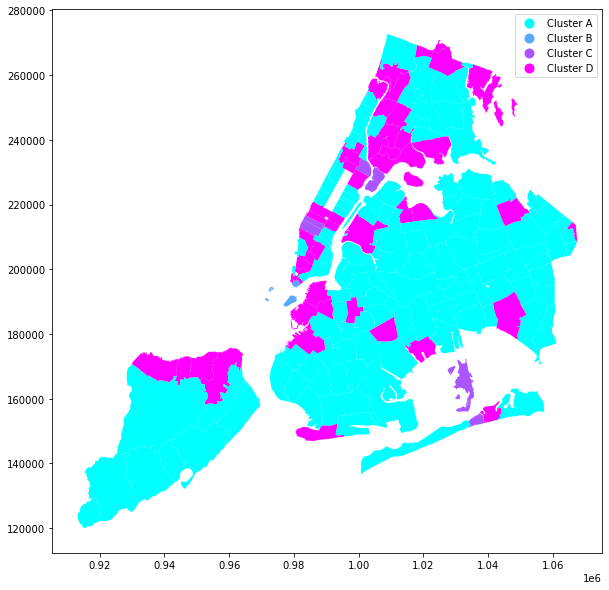

In [80]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize = (20,10))

clusterCrime2018AprPlot.plot(column = 'label', cmap = 'cool', legend = True, ax=ax)

In [81]:
clusterCrime2018AprGraph = Crime_ScaledApr.merge(res,left_index=True, right_on='ZIPCODE').\
                groupby(['label']).sum().reset_index()

clusterCrime2018AprGraph = clusterCrime2018AprGraph[['other crim','personal c', 'property c','statutory', 'traffic cr','label']]
clusterCrime2018AprGraph

,other crim,personal c,property c,statutory,traffic cr,label
0,167.214161,617.612177,863.195118,136.085107,28.615435,0
1,51.211706,106.081390,192.043896,21.947874,1.828989,1
2,65.726328,144.787054,248.264628,47.029739,4.785680,2
3,144.435450,508.203151,718.054898,134.373336,26.834387,3


In [82]:
clusterCrime2018AprGraph

clusterCrime2018AprGraph2 = clusterCrime2018AprGraph[[col for col in clusterCrime2018AprGraph.columns if col in ['other crim','personal c', 'property c','statutory', 'traffic cr']]]
clusterCrime2018AprGraph2 = clusterCrime2018AprGraph2.div(clusterCrime2018AprGraph2.sum(axis=1), axis=0)
clusterCrime2018AprGraph2['label'] = [0,1,2,3]
clusterCrime2018AprGraph2

,other crim,personal c,property c,statutory,traffic cr,label
0,0.092245,0.340710,0.476187,0.075072,0.015786,0
1,0.137255,0.284314,0.514706,0.058824,0.004902,1
2,0.128725,0.283566,0.486228,0.092108,0.009373,2
3,0.094285,0.331747,0.468734,0.087717,0.017517,3


In [83]:
clusterCrime2018AprGraph2['label'] = clusterCrime2018AprGraph2['label'].astype(str)

clusterCrime2018AprGraph2['label'] = clusterCrime2018AprGraph2['label'].replace(['0','1','2','3'],['Cluster A','Cluster B','Cluster C','Cluster D'])

clusterCrime2018AprGraph2 = clusterCrime2018AprGraph2.rename(columns={'other crim': 'other crimes', 'personal c': 'personal crimes', 'property c': 'property crimes', 'statutory': 'drug&alcohol', 'traffic cr': 'traffic crimes'})

clusterCrime2018AprGraph2

,other crimes,personal crimes,property crimes,drug&alcohol,traffic crimes,label
0,0.092245,0.340710,0.476187,0.075072,0.015786,Cluster A
1,0.137255,0.284314,0.514706,0.058824,0.004902,Cluster B
2,0.128725,0.283566,0.486228,0.092108,0.009373,Cluster C
3,0.094285,0.331747,0.468734,0.087717,0.017517,Cluster D


In [84]:
clusterCrime2018AprGraph2.set_index('label', inplace=True)

In [85]:
clusterCrime2018AprGraph2 = clusterCrime2018AprGraph2[["property crimes", "personal crimes", "other crimes", "traffic crimes", "drug&alcohol"]]
clusterCrime2018AprGraph2

,property crimes,personal crimes,other crimes,traffic crimes,drug&alcohol
label,,,,,
Cluster A,0.476187,0.340710,0.092245,0.015786,0.075072
Cluster B,0.514706,0.284314,0.137255,0.004902,0.058824
Cluster C,0.486228,0.283566,0.128725,0.009373,0.092108
Cluster D,0.468734,0.331747,0.094285,0.017517,0.087717


Text(0, 0.5, 'Crime Types')

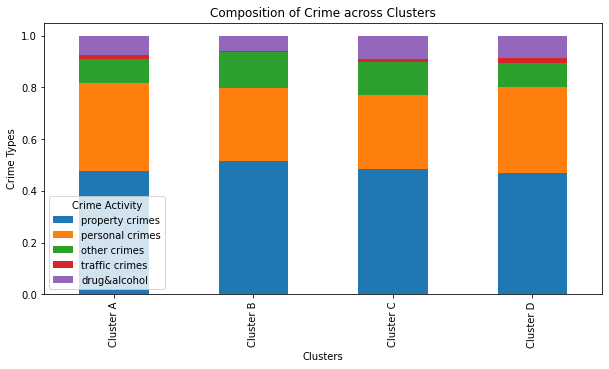

In [86]:
ax = clusterCrime2018AprGraph2.plot(kind='bar', stacked=True, legend=True, figsize=(10, 5))

plt.title("Composition of Crime across Clusters")
plt.legend(title="Crime Activity")
plt.xlabel("Clusters")
plt.ylabel("Crime Types")

# Crime 2019 Data

In [87]:
Crime2019 = gpd.read_file("Data\clean_data\complaint2019Count\complaint2019Count.shp")

Crime2019['ZIPCODE'] = Crime2019['ZIPCODE'].astype(int)
Crime2019['date'] = pd.to_datetime(Crime2019['date'])

Crime2019['Month'] = Crime2019['date'].dt.month
Crime2019['DOW'] = Crime2019['date'].dt.dayofweek
Crime2019.head()

,date,ZIPCODE,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,COUNTY,geometry,Month,DOW
0,2019-03-01,10001,0,2,6,0,0,8,22413.0,New York,"POLYGON ((-74.00827 40.75259, -74.00819 40.752...",3,4
1,2019-03-02,10001,2,1,10,1,0,14,22413.0,New York,"POLYGON ((-74.00827 40.75259, -74.00819 40.752...",3,5
2,2019-03-03,10001,1,0,6,0,0,7,22413.0,New York,"POLYGON ((-74.00827 40.75259, -74.00819 40.752...",3,6
3,2019-03-04,10001,0,0,10,0,0,10,22413.0,New York,"POLYGON ((-74.00827 40.75259, -74.00819 40.752...",3,0
4,2019-03-05,10001,0,2,6,3,0,11,22413.0,New York,"POLYGON ((-74.00827 40.75259, -74.00819 40.752...",3,1


In [88]:
Crime2019DOW = Crime2019.groupby(['DOW']).\
            agg({'other crim':'sum',
                 'personal c':'sum',
                 'property c':'sum',
                 'statutory':'sum', 
                 'traffic cr':'sum', 
                 'total':'sum', 
                 'POPULATION':'mean', 
                 'COUNTY':'count',  }).\
            rename(columns={'COUNTY':'Number of Crime Days'}).reset_index()
Crime2019DOW.head(10)

,DOW,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
0,0,1899,7600,9973,1487,247,21206,45838.255937,3032
1,1,2198,7524,10327,1869,187,22105,46363.060293,3002
2,2,2449,7856,10683,2122,212,23322,46060.581872,3023
3,3,2224,7401,10306,1887,225,22043,46127.688476,3011
4,4,2528,8363,11684,2013,342,24930,45844.156656,3230
5,5,2226,8830,10523,1560,501,23640,45984.168437,3200
6,6,1856,8541,9300,1308,503,21508,46466.793772,3147


Text(0.5, 0, 'Day of Week (Mar - Jun 2019)')

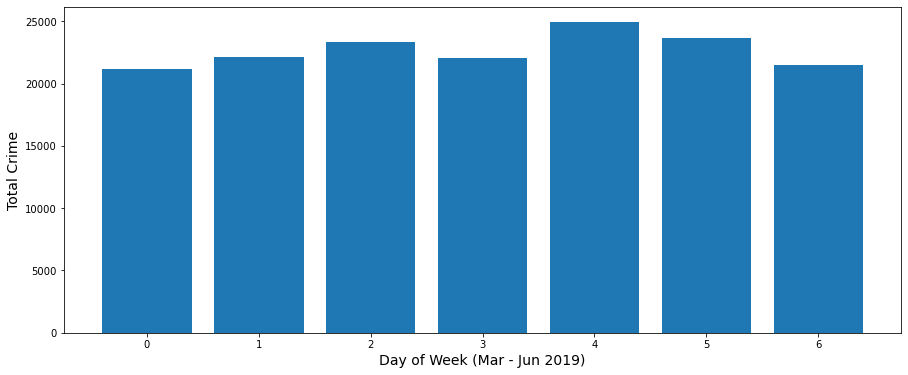

In [89]:
plt.figure(figsize=(15, 6))

plt.bar(Crime2019DOW.DOW, Crime2019DOW.total)
plt.xticks(Crime2019DOW.DOW)
plt.ylabel('Total Crime', fontsize=14)
plt.xlabel('Day of Week (Mar - Jun 2019)', fontsize=14)

In [90]:
Crime2019Month = Crime2019.groupby(['Month']).\
            agg({'other crim':'sum',
                 'personal c':'sum',
                 'property c':'sum',
                 'statutory':'sum', 
                 'traffic cr':'sum', 
                 'total':'sum', 
                 'POPULATION':'mean', 
                 'COUNTY':'count',  }).\
            rename(columns={'COUNTY':'Number of Crime Days'}).reset_index()
Crime2019Month.head(10)

,Month,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
0,3,3978,13023,17147,3018,593,37759,46670.352334,5421
1,4,3782,13226,17184,3022,515,37729,46103.092809,5312
2,5,3906,15079,19062,3210,565,41822,45717.200108,5552
3,6,3714,14787,19403,2996,544,41444,45901.225560,5360


Text(0.5, 0, 'Month (Mar - Jun 2019)')

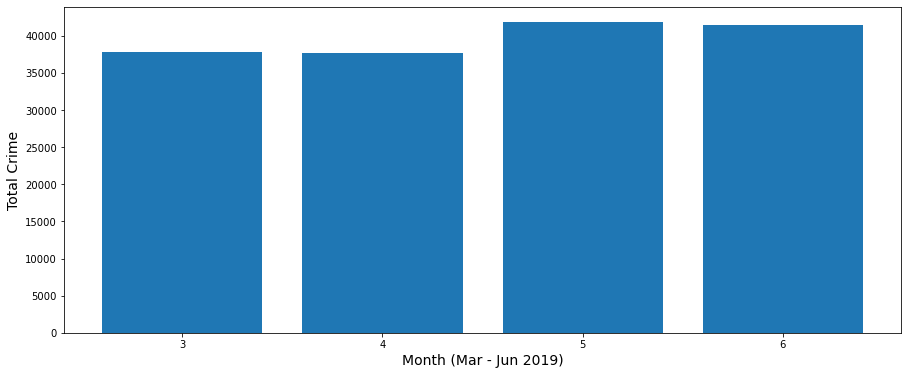

In [91]:
plt.figure(figsize=(15, 6))

plt.bar(Crime2019Month.Month, Crime2019Month.total)
plt.xticks(Crime2019Month.Month)
plt.ylabel('Total Crime', fontsize=14)
plt.xlabel('Month (Mar - Jun 2019)', fontsize=14)

In [92]:
Crime2019grouped = Crime2019.loc[(Crime2019['Month'] == 4 ) | (Crime2019['Month'] == 5 ) | (Crime2019['Month'] == 6 )]

Crime2019grouped = Crime2019.groupby(['ZIPCODE']).\
            agg({'other crim':'sum',
                 'personal c':'sum',
                 'property c':'sum',
                 'statutory':'sum', 
                 'traffic cr':'sum', 
                 'total':'sum', 
                 'POPULATION':'mean', 
                 'COUNTY':'count',  }).\
            rename(columns={'COUNTY':'Number of Crime Days'}).reset_index()

Crime2019grouped.head(10)

,ZIPCODE,other crim,personal c,property c,statutory,traffic cr,total,POPULATION,Number of Crime Days
0,83,9,85,99,10,3,206,25.0,99
1,10001,134,353,1305,142,11,1945,22413.0,122
2,10002,167,691,877,123,14,1872,81305.0,122
3,10003,44,325,951,59,1,1380,55878.0,122
4,10004,56,200,520,80,0,856,2187.0,380
5,10005,8,29,117,13,1,168,8107.0,94
6,10006,4,23,68,11,1,107,3011.0,70
7,10007,31,71,321,24,3,450,7323.0,122
8,10009,109,313,433,82,2,939,61455.0,122
9,10010,45,240,425,29,5,744,29881.0,122


In [93]:
#Crime2019Apr = Crime2019grouped.loc[(Crime2019grouped['Month'] == 4 ) | (Crime2019grouped['Month'] == 5 ) | (Crime2019grouped['Month'] == 6 )]
Crime2019Apr = Crime2019grouped

In [94]:
sanityindex = (Crime2019Apr['POPULATION'] > 1000)
Crime2019Apr = Crime2019Apr.loc[sanityindex]

In [95]:
Crime_ScaledApr = pd.DataFrame(columns = ['ZIPCODE', 'other crim', 'personal c', 'property c', 'statutory', 'traffic cr'])
Crime_ScaledApr['other crim'] = Crime2019Apr['other crim'] / (Crime2019Apr['POPULATION']/1000)
Crime_ScaledApr['personal c'] = Crime2019Apr['personal c'] / (Crime2019Apr['POPULATION']/1000)
Crime_ScaledApr['property c'] = Crime2019Apr['property c'] / (Crime2019Apr['POPULATION']/1000)
Crime_ScaledApr['statutory'] = Crime2019Apr['statutory'] / (Crime2019Apr['POPULATION']/1000)
Crime_ScaledApr['traffic cr'] = Crime2019Apr['traffic cr'] / (Crime2019Apr['POPULATION']/1000)
Crime_ScaledApr['ZIPCODE'] = Crime2019Apr['ZIPCODE']

Crime_ScaledApr.set_index('ZIPCODE', inplace=True)

Crime_ScaledApr

,other crim,personal c,property c,statutory,traffic cr
ZIPCODE,,,,,
10001,5.978673,15.749788,58.225137,6.335609,0.490787
10002,2.053994,8.498862,10.786544,1.512822,0.172191
10003,0.787430,5.816243,17.019220,1.055872,0.017896
10004,25.605853,91.449474,237.768633,36.579790,0.000000
10005,0.986802,3.577156,14.431972,1.603552,0.123350
...,...,...,...,...,...
11691,2.771002,10.619410,7.699072,1.028755,0.248892
11692,3.330003,10.045510,8.547009,1.221001,0.166500
11693,17.372421,59.355773,44.516830,8.686211,2.895404


In [96]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [ 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(Crime_ScaledApr)
    #report average Silhouette score
    silhouette_avg = silhouette_score(Crime_ScaledApr, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.9501227127960302
For n_clusters =3, the average silhouette_score is :0.8385651224867533
For n_clusters =4, the average silhouette_score is :0.5515798845784742
For n_clusters =5, the average silhouette_score is :0.4746878959426606
For n_clusters =6, the average silhouette_score is :0.4752275159215481
For n_clusters =7, the average silhouette_score is :0.44595616760134654
For n_clusters =8, the average silhouette_score is :0.44225722582894517
For n_clusters =9, the average silhouette_score is :0.3431294001895479
For n_clusters =10, the average silhouette_score is :0.35877994101966565
For n_clusters =11, the average silhouette_score is :0.3499316597582301
For n_clusters =12, the average silhouette_score is :0.3123187606669076
For n_clusters =13, the average silhouette_score is :0.30928442518839927
For n_clusters =14, the average silhouette_score is :0.3396778746949991
For n_clusters =15, the average silhouette_score is :0.3447432217554

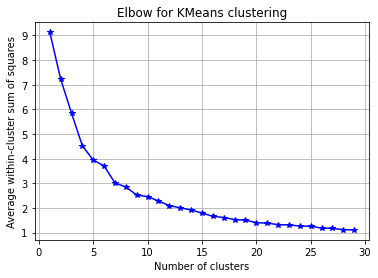

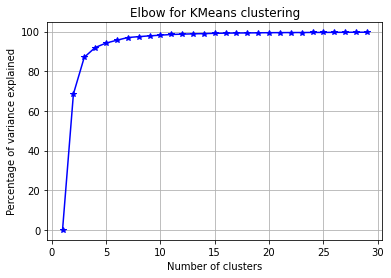

In [97]:
elbow(Crime_ScaledApr, range(1,30))

In [98]:
from sklearn.mixture import GaussianMixture # You can import this only if you are using 0.18+ sklearn.
GauMix = GaussianMixture(n_components = 4, random_state = 0).fit(Crime_ScaledApr)
GauMix.labels_ = GauMix.predict(Crime_ScaledApr) #get labels

max(GauMix.labels_)

3

In [99]:
res=pd.DataFrame({'ZIPCODE':Crime_ScaledApr.index,'label':GauMix.labels_})
res

,ZIPCODE,label
0,10001,2
1,10002,0
2,10003,0
3,10004,1
4,10005,0
...,...,...
177,11691,0
178,11692,0
179,11693,2
180,11694,0


In [100]:
clusterCrime2019Apr = Crime_ScaledApr.merge(res,left_index=True, right_on='ZIPCODE')
clusterCrime2019Apr

,other crim,personal c,property c,statutory,traffic cr,ZIPCODE,label
0,5.978673,15.749788,58.225137,6.335609,0.490787,10001,2
1,2.053994,8.498862,10.786544,1.512822,0.172191,10002,0
2,0.787430,5.816243,17.019220,1.055872,0.017896,10003,0
3,25.605853,91.449474,237.768633,36.579790,0.000000,10004,1
4,0.986802,3.577156,14.431972,1.603552,0.123350,10005,0
...,...,...,...,...,...,...,...
177,2.771002,10.619410,7.699072,1.028755,0.248892,11691,0
178,3.330003,10.045510,8.547009,1.221001,0.166500,11692,0
179,17.372421,59.355773,44.516830,8.686211,2.895404,11693,2
180,0.843129,5.257154,4.166047,0.743937,0.247979,11694,0


In [101]:
zips = gpd.read_file("Data/ZIP_CODE_040114/ZIP_CODE_040114.shp")
zips = zips[['ZIPCODE', 'POPULATION', 'geometry']]
zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)
zips.head()

,ZIPCODE,POPULATION,geometry
0,11436,18681.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,62426.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,83866.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,56527.0,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,72280.0,"POLYGON ((991997.113 176307.496, 992042.798 17..."


In [102]:
clusterCrime2019AprPlot = zips.merge(clusterCrime2019Apr,left_on='ZIPCODE',right_on='ZIPCODE',how='right')

clusterCrime2019AprPlot

,ZIPCODE,POPULATION,geometry,other crim,personal c,property c,statutory,traffic cr,label
0,10001,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",5.978673,15.749788,58.225137,6.335609,0.490787,2
1,10002,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",2.053994,8.498862,10.786544,1.512822,0.172191,0
2,10003,55878.0,"POLYGON ((989830.469 207048.126, 989716.354 20...",0.787430,5.816243,17.019220,1.055872,0.017896,0
3,10004,2187.0,"POLYGON ((981197.409 196571.082, 981485.049 19...",25.605853,91.449474,237.768633,36.579790,0.000000,1
4,10004,2187.0,"POLYGON ((972696.845 193014.548, 972500.000 19...",25.605853,91.449474,237.768633,36.579790,0.000000,1
...,...,...,...,...,...,...,...,...,...
189,11693,11052.0,"POLYGON ((1030722.649 160980.770, 1030642.283 ...",17.372421,59.355773,44.516830,8.686211,2.895404,2
190,11693,11052.0,"POLYGON ((1036087.150 154632.639, 1036096.661 ...",17.372421,59.355773,44.516830,8.686211,2.895404,2
191,11693,11052.0,"POLYGON ((1028453.995 167153.410, 1027813.010 ...",17.372421,59.355773,44.516830,8.686211,2.895404,2
192,11694,20163.0,"POLYGON ((1034425.420 153503.826, 1034416.180 ...",0.843129,5.257154,4.166047,0.743937,0.247979,0


In [103]:
clusterCrime2019AprPlot['label'] = clusterCrime2019AprPlot['label'].astype(str)

clusterCrime2019AprPlot = clusterCrime2019AprPlot[['ZIPCODE','label','geometry']]
clusterCrime2019AprPlot

,ZIPCODE,label,geometry
0,10001,2,"POLYGON ((981958.647 213464.453, 981980.328 21..."
1,10002,0,"POLYGON ((991339.870 207576.784, 991330.490 20..."
2,10003,0,"POLYGON ((989830.469 207048.126, 989716.354 20..."
3,10004,1,"POLYGON ((981197.409 196571.082, 981485.049 19..."
4,10004,1,"POLYGON ((972696.845 193014.548, 972500.000 19..."
...,...,...,...
189,11693,2,"POLYGON ((1030722.649 160980.770, 1030642.283 ..."
190,11693,2,"POLYGON ((1036087.150 154632.639, 1036096.661 ..."
191,11693,2,"POLYGON ((1028453.995 167153.410, 1027813.010 ..."
192,11694,0,"POLYGON ((1034425.420 153503.826, 1034416.180 ..."


In [104]:
clusterCrime2019AprPlot['label'] = clusterCrime2019AprPlot['label'].replace(['0','1','2','3'],['Cluster A','Cluster B','Cluster C','Cluster D'])
clusterCrime2019AprPlot

,ZIPCODE,label,geometry
0,10001,Cluster C,"POLYGON ((981958.647 213464.453, 981980.328 21..."
1,10002,Cluster A,"POLYGON ((991339.870 207576.784, 991330.490 20..."
2,10003,Cluster A,"POLYGON ((989830.469 207048.126, 989716.354 20..."
3,10004,Cluster B,"POLYGON ((981197.409 196571.082, 981485.049 19..."
4,10004,Cluster B,"POLYGON ((972696.845 193014.548, 972500.000 19..."
...,...,...,...
189,11693,Cluster C,"POLYGON ((1030722.649 160980.770, 1030642.283 ..."
190,11693,Cluster C,"POLYGON ((1036087.150 154632.639, 1036096.661 ..."
191,11693,Cluster C,"POLYGON ((1028453.995 167153.410, 1027813.010 ..."
192,11694,Cluster A,"POLYGON ((1034425.420 153503.826, 1034416.180 ..."


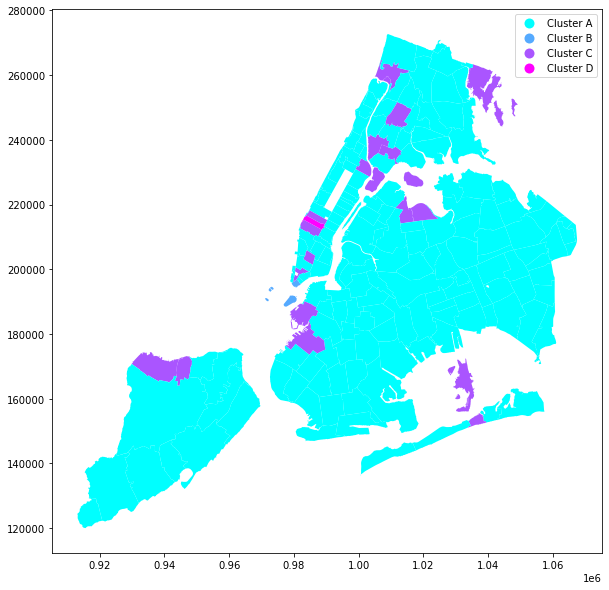

In [105]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize = (20,10))

clusterCrime2019AprPlot.plot(column = 'label', cmap = 'cool', legend = True, ax=ax)

In [106]:
clusterCrime2019AprGraph = Crime_ScaledApr.merge(res,left_index=True, right_on='ZIPCODE').\
                groupby(['label']).sum().reset_index()

clusterCrime2019AprGraph = clusterCrime2019AprGraph[['other crim','personal c', 'property c','statutory', 'traffic cr','label']]
clusterCrime2019AprGraph

,other crim,personal c,property c,statutory,traffic cr,label
0,253.016426,966.847572,1271.283294,189.034408,37.364666,0
1,25.605853,91.449474,237.768633,36.579790,0.000000,1
2,87.915959,279.207240,425.797125,94.178475,16.073821,2
3,11.266582,53.243685,89.224060,17.263311,3.089224,3


In [107]:
clusterCrime2019AprGraph

clusterCrime2019AprGraph2 = clusterCrime2019AprGraph[[col for col in clusterCrime2019AprGraph.columns if col in ['other crim','personal c', 'property c','statutory', 'traffic cr']]]
clusterCrime2019AprGraph2 = clusterCrime2019AprGraph2.div(clusterCrime2019AprGraph2.sum(axis=1), axis=0)
clusterCrime2019AprGraph2['label'] = [0,1,2,3]
clusterCrime2019AprGraph2

,other crim,personal c,property c,statutory,traffic cr,label
0,0.093105,0.355780,0.467806,0.069561,0.013749,0
1,0.065421,0.233645,0.607477,0.093458,0.000000,1
2,0.097341,0.309141,0.471446,0.104275,0.017797,2
3,0.064718,0.305846,0.512526,0.099165,0.017745,3


In [108]:
clusterCrime2019AprGraph2['label'] = clusterCrime2019AprGraph2['label'].astype(str)

clusterCrime2019AprGraph2['label'] = clusterCrime2019AprGraph2['label'].replace(['0','1','2','3'],['Cluster A','Cluster B','Cluster C','Cluster D'])

clusterCrime2019AprGraph2 = clusterCrime2019AprGraph2.rename(columns={'other crim': 'other crimes', 'personal c': 'personal crimes', 'property c': 'property crimes', 'statutory': 'drug&alcohol', 'traffic cr': 'traffic crimes'})

clusterCrime2019AprGraph2

,other crimes,personal crimes,property crimes,drug&alcohol,traffic crimes,label
0,0.093105,0.355780,0.467806,0.069561,0.013749,Cluster A
1,0.065421,0.233645,0.607477,0.093458,0.000000,Cluster B
2,0.097341,0.309141,0.471446,0.104275,0.017797,Cluster C
3,0.064718,0.305846,0.512526,0.099165,0.017745,Cluster D


In [109]:
clusterCrime2019AprGraph2.set_index('label', inplace=True)

In [110]:
clusterCrime2019AprGraph2 = clusterCrime2019AprGraph2[["property crimes", "personal crimes", "other crimes", "traffic crimes", "drug&alcohol"]]
clusterCrime2019AprGraph2

,property crimes,personal crimes,other crimes,traffic crimes,drug&alcohol
label,,,,,
Cluster A,0.467806,0.355780,0.093105,0.013749,0.069561
Cluster B,0.607477,0.233645,0.065421,0.000000,0.093458
Cluster C,0.471446,0.309141,0.097341,0.017797,0.104275
Cluster D,0.512526,0.305846,0.064718,0.017745,0.099165


Text(0, 0.5, 'Crime Types')

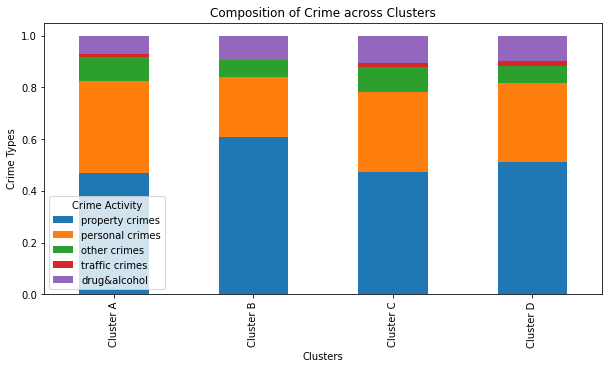

In [111]:
ax = clusterCrime2019AprGraph2.plot(kind='bar', stacked=True, legend=True, figsize=(10, 5))

plt.title("Composition of Crime across Clusters")
plt.legend(title="Crime Activity")
plt.xlabel("Clusters")
plt.ylabel("Crime Types")